In [1]:
import datajoint as dj

In [2]:
import requests

In [3]:
dj.conn()

Connecting root@localhost:3306


DataJoint connection (connected) root@localhost:3306

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

In [5]:
schema = dj.schema('states')

In [6]:
states = dict(
    AL='Alabama',        AK='Alaska',       AZ='Arizona',      AR='Arkansas',
    CA='California',     CO='Colorado',     CT='Connecticut',  DE='Delaware',
    FL='Florida',        GA='Georgia',      HI='Hawaii',       ID='Idaho', 
    IL='Illinois',       IN='Indiana',      IA='Iowa',         KS='Kansas',
    KY='Kentucky',       LA='Louisiana',    ME='Maine',        MD='Maryland',
    MA='Massachusetts',  MI='Michigan',     MN='Minnesota',    MS='Mississippi',
    MO='Missouri',       MT='Montana',      NE='Nebraska',     NV='Nevada',
    NH='New Hampshire',  NJ='New Jersey',   NM='New Mexico',   NY='New York',
    NC='North Carolina', ND='North Dakota', OH='Ohio',         OK='Oklahoma',
    OR='Oregon',         PA='Pennsylvania', RI='Rhode Island', SC='South Carolina',
    SD='South Dakota',   TN='Tennessee',    TX='Texas',        UT='Utah',
    VT='Vermont',        VA='Virginia',     WA='Washington',   WV='West Virginia', 
    WI='Wisconsin',      WY='Wyoming')

In [7]:
@schema
class State(dj.Lookup):
    definition = """
    # United States
    state_code : char(2)
    ---
    state : varchar(20)
    """
    contents = states.items()

In [8]:
State()

state_code,state
AK,Alaska
AL,Alabama
AR,Arkansas
AZ,Arizona
CA,California
CO,Colorado
CT,Connecticut
DE,Delaware
FL,Florida
GA,Georgia


In [9]:
def download(url):
    path = url.split('/') [-1]
    with open(path, 'wb') as f:
        f.write(requests.get(url).content)
        return path

In [10]:
download("http://www.theus50.com/images/state-birds/{state}-bird.jpg")

'{state}-bird.jpg'

In [11]:
@schema
class StateBird(dj.Imported):
    definition = """
    -> State
    ---
    bird_image : longblob    
    """
    
    url_template = "http://www.theus50.com/images/state-birds/{state}-bird.jpg"
    
    def make(self, key):
        # fetch data upstream
        state = (State & key).fetch1('state')
        
        # compute
        url = self.url_template.format(state=state.lower().replace(' ', ''))
        temp_file = 'tmp.jpg'
        with open(temp_file, 'wb') as f:
            f.write(requests.get(url).content)
        
        # insert into self
        self.insert1(dict(key, bird_image=plt.imread(temp_file)))

In [12]:
StateBird().populate(display_progress=True, suppress_errors=True)

StateBird: 0it [00:00, ?it/s]


[]

In [13]:
StateBird()

state_code,bird_image
AK,=BLOB=
AL,=BLOB=
AR,=BLOB=
AZ,=BLOB=
CA,=BLOB=
CO,=BLOB=
CT,=BLOB=
DE,=BLOB=
FL,=BLOB=
GA,=BLOB=


In [14]:
img = (StateBird & {'state_code': "TX"}).fetch1('bird_image')

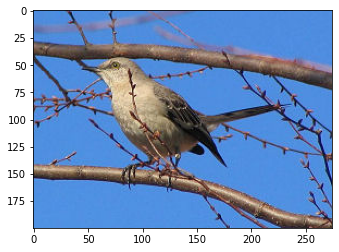

In [15]:
plt.imshow(img)

In [16]:
download("http://www.theus50.com/images/state-flags/{state}-flag.jpg")

'{state}-flag.jpg'

In [23]:
@schema
class StateFlag(dj.Imported):
    definition = """
    -> State
    ---
    flag_image : longblob    
    """
    
    url_template = "http://www.theus50.com/images/state-flags/{state}-flag.jpg"
    
    def make(self, key):
        state = (State & key).fetch1('state')
        url = self.url_template.format(state=state.lower().replace(' ', ''))
        temp_file = 'tmp.jpg'
        with open(temp_file, 'wb') as f:
            f.write(requests.get(url).content)
        self.insert1(dict(key, flag_image=plt.imread(temp_file)))

In [24]:
StateFlag.populate(display_progress=True)

StateFlag: 100%|██████████| 50/50 [00:08<00:00,  5.63it/s]


In [25]:
img = (StateFlag & {'state_code': "TX"}).fetch1('flag_image')

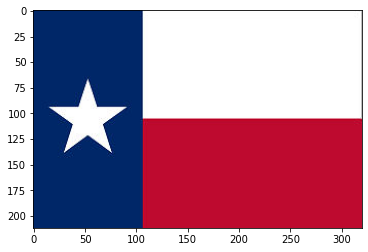

In [26]:
plt.imshow(img)

In [ ]:
download("http://www.theus50.com/images/state-flowers/{state}-flower.jpg")

In [30]:
@schema
class StateFlower(dj.Imported):
    definition = """
    -> State
    ---
    flower_image : longblob    
    """
    
    url_template = "http://www.theus50.com/images/state-flowers/{state}-flower.jpg"
    
    def make(self, key):
        state = (State & key).fetch1('state')
        url = self.url_template.format(state=state.lower().replace(' ', ''))
        temp_file = 'tmp.jpg'
        with open(temp_file, 'wb') as f:
            f.write(requests.get(url).content)
        self.insert1(dict(key, flower_image=plt.imread(temp_file)))

In [31]:
StateFlower.populate(display_progress=True)

StateFlower: 100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


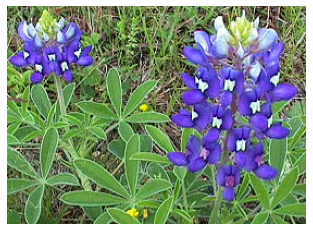

In [33]:
plt.imshow((StateFlower & {'state_code': 'TX'}).fetch1('flower_image'))
plt.axis(False);

In [34]:
StateFlag * State

state_code,flag_image,state
AK,=BLOB=,Alaska
AL,=BLOB=,Alabama
AR,=BLOB=,Arkansas
AZ,=BLOB=,Arizona
CA,=BLOB=,California
CO,=BLOB=,Colorado
CT,=BLOB=,Connecticut
DE,=BLOB=,Delaware
FL,=BLOB=,Florida
GA,=BLOB=,Georgia


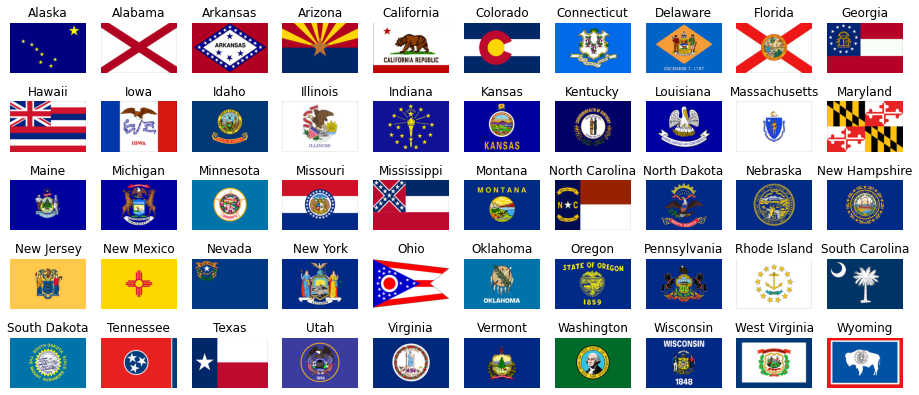

In [35]:
fig, axx = plt.subplots(5, 10, figsize=(16, 7))

for ax, info in zip(axx.flatten(), 
                    (StateFlag*State).fetch(as_dict=True)):
    ax.imshow(info['flag_image'])
    ax.set_title(info['state'])
    ax.axis(False)

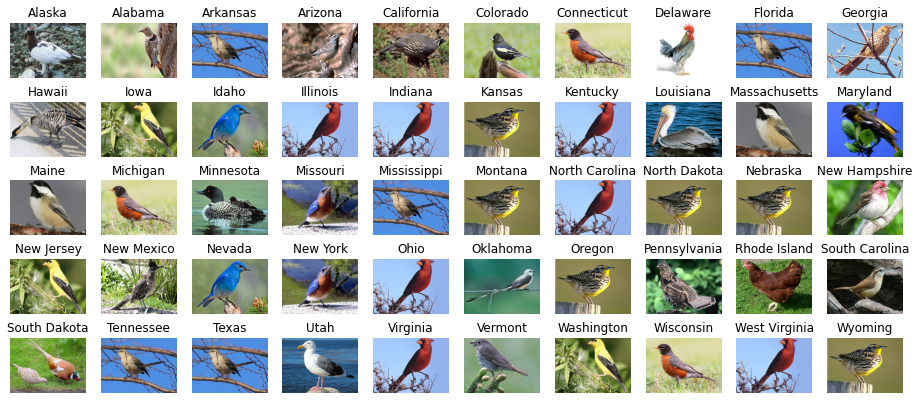

In [36]:
fig, axx = plt.subplots(5, 10, figsize=(16, 7))
for ax, info in zip(axx.flatten(), 
                    (StateBird*State).fetch(as_dict=True)):
    ax.imshow(info['bird_image'])
    ax.set_title(info['state'])
    ax.axis(False)

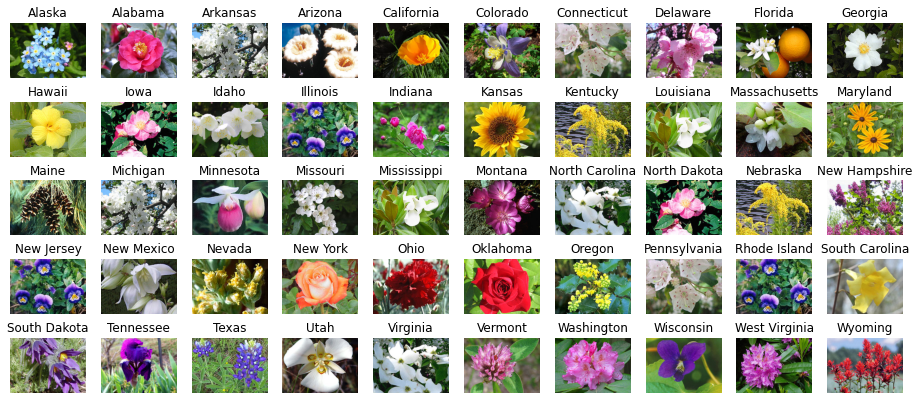

In [37]:
fig, axx = plt.subplots(5, 10, figsize=(16, 7))
for ax, info in zip(axx.flatten(), 
                    (StateFlower*State).fetch(as_dict=True)):
    ax.imshow(info['flower_image'])
    ax.set_title(info['state'])
    ax.axis(False)

In [46]:
@schema
class FlagSaturation(dj.Computed):
    definition = """
    -> StateFlag
    ---
    saturation :  float 
    """
    
    def make(self, key):
        img = (StateFlag & key).fetch1('flag_image')
        avg_color = img.mean(axis=(0,1))
        sat = avg_color.max()/avg_color.sum()
        self.insert1(dict(key, saturation=sat))
        

In [49]:
FlagSaturation.populate(display_progress=True)

FlagSaturation: 0it [00:00, ?it/s]


In [50]:
FlagSaturation * State * StateFlag

state_code,saturation,state,flag_image
AK,0.91892,Alaska,=BLOB=
AL,0.400431,Alabama,=BLOB=
AR,0.487462,Arkansas,=BLOB=
AZ,0.454226,Arizona,=BLOB=
CA,0.378853,California,=BLOB=
CO,0.390371,Colorado,=BLOB=
CT,0.560019,Connecticut,=BLOB=
DE,0.471179,Delaware,=BLOB=
FL,0.42982,Florida,=BLOB=
GA,0.476412,Georgia,=BLOB=


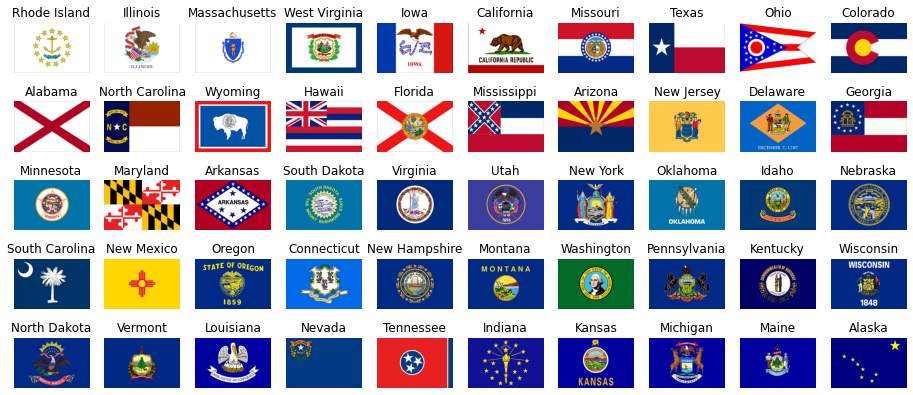

In [51]:
fig, axx = plt.subplots(5, 10, figsize=(16, 7))

for ax, info in zip(axx.flatten(), 
                    (StateFlag*State*FlagSaturation).fetch(as_dict=True, order_by='saturation')):
    ax.imshow(info['flag_image'])
    ax.set_title(info['state'])
    ax.axis(False)

In [ ]:
StateFlower.populate()
StateFlag.populate()
StateBird.populate()
FlagSaturation.populate()

In [55]:
@schema
class FlagBrightness(dj.Computed):
    definition = """
    -> StateFlag
    ---
    brightness :  float 
    """
    
    def make(self, key):
        img = (StateFlag & key).fetch1('flag_image')
        self.insert1(dict(key, brightness=img.mean()))

In [56]:
FlagBrightness.populate()

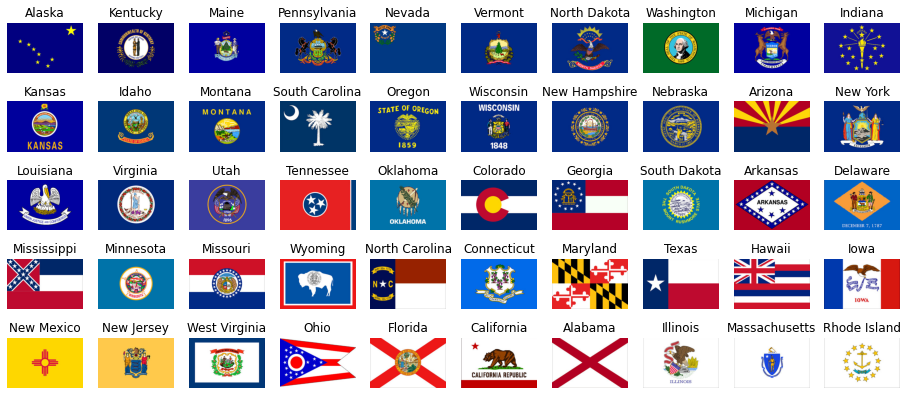

In [57]:
fig, axx = plt.subplots(5, 10, figsize=(16, 7))

for ax, info in zip(axx.flatten(), 
                    (StateFlag*State*FlagBrightness).fetch(as_dict=True, order_by='brightness')):
    ax.imshow(info['flag_image'])
    ax.set_title(info['state'])
    ax.axis(False)

In [61]:
@schema
class FlagContrast(dj.Computed):
    definition = """
    -> FlagBrightness
    ---
    contrast :  float 
    """
    
    def make(self, key):
        img, brightness = (StateFlag * FlagBrightness & key).fetch1('flag_image', 'brightness')
        self.insert1(dict(key, contrast=img.mean(axis=-1).std()/brightness))

In [62]:
FlagContrast.populate()

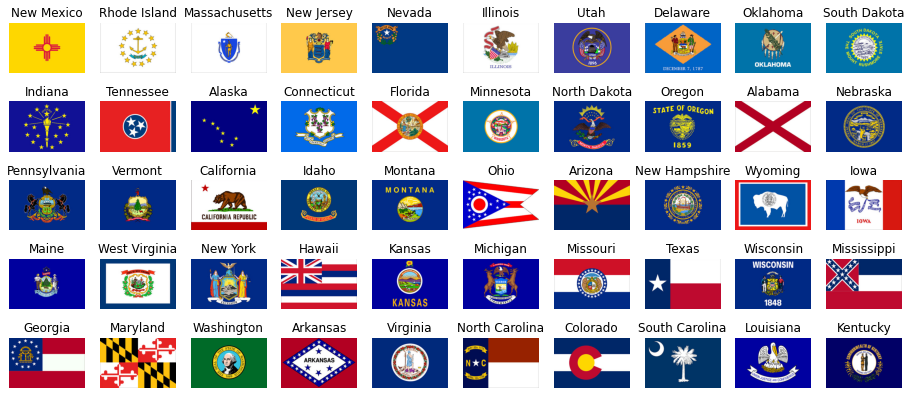

In [63]:
fig, axx = plt.subplots(5, 10, figsize=(16, 7))

for ax, info in zip(axx.flatten(), 
                    (StateFlag*State*FlagContrast).fetch(as_dict=True, order_by='contrast')):
    ax.imshow(info['flag_image'])
    ax.set_title(info['state'])
    ax.axis(False)

In [ ]:
@schema
class FlagHue(dj.Computed):
    definition = """
    -> FlagSaturation
    ---
    hue :  float 
    """
    
    def make(self, key):
        img, saturation = (StateFlag * FlagSaturation & key).fetch1('flag_image', 'saturation')
        self.insert1(dict(key, hue=img.mean(axis = -1).std()/saturation))
        

In [ ]:
FlagHue.populate(display_progress=True)

In [ ]:
fig, axx = plt.subplots(5, 10, figsize=(16, 7))

for ax, info in zip(axx.flatten(), 
                    (StateFlag*State*FlagHue).fetch(as_dict=True, order_by='hue')):
    ax.imshow(info['flag_image'])
    ax.set_title(info['state'])
    ax.axis(False)

In [ ]:
dj.Diagram(schema)